## Setting

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append("/content/drive/My Drive/LCNN/")

import os
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt



import imp
import importlib
import LCNN
imp.reload(LCNN)
from LCNN import adjust,accuracy,one_hot
device = torch.device('cuda')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
batchsize=64

trainset = datasets.MNIST('/content/drive/My Drive/data', download=True, train=True, transform=transform)
valset = datasets.MNIST('/content/drive/My Drive/data', download=True, train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)

In [ ]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

hidden_size2 = 200

hidden_size3 = 100


num_classes = 10
batch_size = 64


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 
        self.hidden_size1 = hidden_size1
        #self.fc1.weight.detach().normal_(0.0, 0.1)
        #self.fc1.bias.detach().normal_(0.0, 0.1)
        
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2,bias=False)
        #self.fc2.weight.detach().uniform_(-1,1)
        
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu2 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, num_classes,bias=False)




        self.lsm=nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        
        
        out = self.fc3(out)
        out = self.relu2(out)
        out = self.fc4(out)
        
        out = self.lsm(out)
        return out

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


## Original Training

In [ ]:
learning_rate = 0.01
torch.manual_seed(0)
device = torch.device('cuda')
model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)
ad=True
if ad:
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1)

    adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)
    
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()
num_epochs=700
dev=100
losslist=[]


totalloss=[]



model.fc2.register_forward_hook(get_activation('fc2'))
#model.fc4.register_forward_hook(get_activation('fc4'))
#model.fc6.register_forward_hook(get_activation('fc6'))

count=0
dd=-10
de=1
for epoch in range(num_epochs):
    loss_epoch=0
    for i, (images, labels) in enumerate(train_loader):  
        

        images = images.view(images.shape[0], -1).to(device)
        labels=labels.to(device)
        #
        # Forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)
        
        
        totalloss.append(loss.item())
        #if epoch<1:
        #    print(count,loss.item())
        loss_epoch=loss_epoch+loss.item()       
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        count=count+1

        if ad:
            if count==dd:
                with torch.no_grad():
                    output = model(images)
                    adjust(model,activation['fc'+str(2*de)],threshold_u=10,threshold_l=0.1,scale=0.4,ln=2*de+1,oflag=1)

                    
                    
        
    loss_epoch=loss_epoch/len(train_loader) 
    losslist.append(loss_epoch)
    
    print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, loss_epoch))
    if loss_epoch<0.02:
        break

Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
Epoch [1/700], Loss: 0.5157


KeyboardInterrupt: ignored

In [ ]:
accuracy(model.to(device),valloader)
out=[losslist,totalloss]

NameError: ignored

## Modify first layer (learning rate 0.01)

In [ ]:
out=[]
for p in [-2,-1,0,1,5,10,50,100,1000]:
    print(p)
    learning_rate = 0.01
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)
    if p>-2:
        ad=True
    else:
        ad=False
    if ad:
        dataiter = iter(train_loader)
        images, labels = dataiter.next()
        images = images.view(images.shape[0], -1)

        adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)
        
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0)
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    num_epochs=700
    dev=100
    losslist=[]


    totalloss=[]



    model.fc2.register_forward_hook(get_activation('fc2'))
    #model.fc4.register_forward_hook(get_activation('fc4'))
    #model.fc6.register_forward_hook(get_activation('fc6'))

    count=0
    dd=p
    de=1
    for epoch in range(num_epochs):
        loss_epoch=0
        for i, (images, labels) in enumerate(train_loader):


            

            images = images.view(images.shape[0], -1).to(device)
            labels=labels.to(device)
            #
            # Forward pass
            outputs = model(images).to(device)
            loss = criterion(outputs, labels).to(device)


            

            if ad:
                if count==dd:
                    with torch.no_grad():
                        output = model(images)
                        adjust(model,activation['fc'+str(2*de)],threshold_u=10,threshold_l=0.1,scale=0.4,ln=2*de+1,oflag=1)  
            
            count=count+1
            
            totalloss.append(loss.item())
            #if epoch<1:
            #    print(count,loss.item())
            loss_epoch=loss_epoch+loss.item()       
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            


                        
                        
            
        loss_epoch=loss_epoch/len(train_loader) 
        losslist.append(loss_epoch)
        
        #print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, loss_epoch))
        if loss_epoch<0.02:
            break
    out.append([losslist,totalloss])

-2
-1
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
0
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
Adjusting Layer 3, Kernel Nodes: 81, Adptive Nodes19
1
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
Adjusting Layer 3, Kernel Nodes: 81, Adptive Nodes19
5
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
Adjusting Layer 3, Kernel Nodes: 82, Adptive Nodes18
10
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
Adjusting Layer 3, Kernel Nodes: 80, Adptive Nodes20
50
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
Adjusting Layer 3, Kernel Nodes: 81, Adptive Nodes19
100
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
Adjusting Layer 3, Kernel Nodes: 81, Adptive Nodes19
1000
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
Adjusting Layer 3, Kernel Nodes: 81, Adptive Nodes19


In [ ]:
np.save('/content/drive/My Drive/LCNN/output.npy', out)

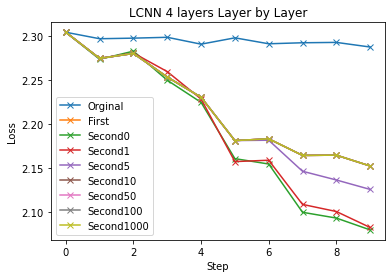

In [ ]:
plt.plot(out[0][1][:10],'x-',label='Orginal')
plt.plot(out[1][1][:10],'x-',label='First')
plt.plot(out[2][1][:10],'x-',label='Second0')
plt.plot(out[3][1][:10],'x-',label='Second1')
plt.plot(out[4][1][:10],'x-',label='Second5')
plt.plot(out[5][1][:10],'x-',label='Second10')
plt.plot(out[6][1][:10],'x-',label='Second50')
plt.plot(out[7][1][:10],'x-',label='Second100')
plt.plot(out[8][1][:10],'x-',label='Second1000')

#plt.plot(totalloss[:400],'x-',label='layer by layer')
#plt.plot([50,50],[0,2.5],color='black')
plt.title('LCNN 4 layers Layer by Layer')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Step')
plt.savefig('/content/drive/My Drive/LCNN/plot/4layertt1.pdf')

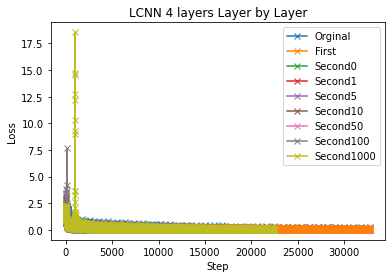

In [ ]:
plt.plot(out[0][1],'x-',label='Orginal')
plt.plot(out[1][1],'x-',label='First')
plt.plot(out[2][1],'x-',label='Second0')
plt.plot(out[3][1],'x-',label='Second1')
plt.plot(out[4][1],'x-',label='Second5')
plt.plot(out[5][1],'x-',label='Second10')
plt.plot(out[6][1],'x-',label='Second50')
plt.plot(out[7][1],'x-',label='Second100')
plt.plot(out[8][1],'x-',label='Second1000')

#plt.plot(totalloss[:400],'x-',label='layer by layer')
#plt.plot([50,50],[0,2.5],color='black')
plt.title('LCNN 4 layers Layer by Layer')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Step')
plt.savefig('/content/drive/My Drive/LCNN/plot/4layertt2.pdf')

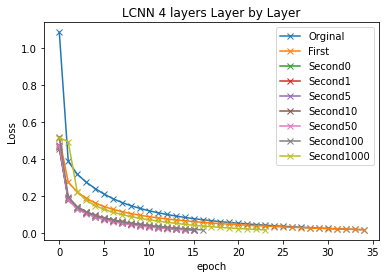

In [ ]:
plt.plot(out[0][0],'x-',label='Orginal')
plt.plot(out[1][0],'x-',label='First')
plt.plot(out[2][0],'x-',label='Second0')
plt.plot(out[3][0],'x-',label='Second1')
plt.plot(out[4][0],'x-',label='Second5')
plt.plot(out[5][0],'x-',label='Second10')
plt.plot(out[6][0],'x-',label='Second50')
plt.plot(out[7][0],'x-',label='Second100')
plt.plot(out[8][0],'x-',label='Second1000')

#plt.plot(totalloss[:400],'x-',label='layer by layer')
#plt.plot([50,50],[0,2.5],color='black')
plt.title('LCNN 4 layers Layer by Layer')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.savefig('/content/drive/My Drive/LCNN/plot/4layerlt1.pdf')

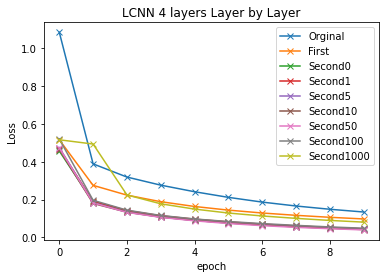

In [ ]:
plt.plot(out[0][0][:10],'x-',label='Orginal')
plt.plot(out[1][0][:10],'x-',label='First')
plt.plot(out[2][0][:10],'x-',label='Second0')
plt.plot(out[3][0][:10],'x-',label='Second1')
plt.plot(out[4][0][:10],'x-',label='Second5')
plt.plot(out[5][0][:10],'x-',label='Second10')
plt.plot(out[6][0][:10],'x-',label='Second50')
plt.plot(out[7][0][:10],'x-',label='Second100')
plt.plot(out[8][0][:10],'x-',label='Second1000')

#plt.plot(totalloss[:400],'x-',label='layer by layer')
#plt.plot([50,50],[0,2.5],color='black')
plt.title('LCNN 4 layers Layer by Layer')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.savefig('/content/drive/My Drive/LCNN/plot/4layerlt2.pdf')

(990.0, 1010.0)

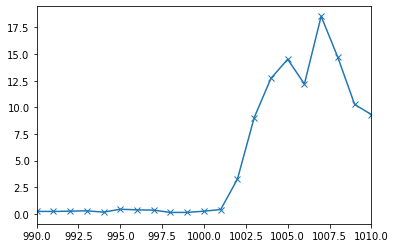

In [ ]:
plt.plot(out[8][1],'x-',label='Second1000')
plt.xlim([990,1010])

## (learning rate 0.002)

In [ ]:
out=[]
for p in [-2,-1,0,1,2,4,8,16,32,64,128]:
    print(p)
    learning_rate = 0.002
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)
    if p>-2:
        ad=True
    else:
        ad=False
    if ad:
        dataiter = iter(train_loader)
        images, labels = dataiter.next()
        images = images.view(images.shape[0], -1)

        adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)
        
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0)
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    num_epochs=700
    dev=100
    losslist=[]


    totalloss=[]



    model.fc2.register_forward_hook(get_activation('fc2'))
    #model.fc4.register_forward_hook(get_activation('fc4'))
    #model.fc6.register_forward_hook(get_activation('fc6'))

    count=0
    dd=p
    de=1
    for epoch in range(num_epochs):
        loss_epoch=0
        for i, (images, labels) in enumerate(train_loader):


            

            images = images.view(images.shape[0], -1).to(device)
            labels=labels.to(device)
            #
            # Forward pass
            outputs = model(images).to(device)
            loss = criterion(outputs, labels).to(device)


            

            if ad:
                if count==dd:
                    with torch.no_grad():
                        output = model(images)
                        adjust(model,activation['fc'+str(2*de)],threshold_u=10,threshold_l=0.1,scale=0.4,ln=2*de+1,oflag=1)  
            
            count=count+1
            
            totalloss.append(loss.item())
            #if epoch<1:
            #    print(count,loss.item())
            loss_epoch=loss_epoch+loss.item()       
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            


                        
                        
            
        loss_epoch=loss_epoch/len(train_loader) 
        losslist.append(loss_epoch)
        
        #print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, loss_epoch))
        if loss_epoch<0.02:
            break
    out.append([losslist,totalloss])
np.save('/content/drive/My Drive/LCNN/output1024.npy', out)

-2
-1
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
0
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
Adjusting Layer 3, Kernel Nodes: 81, Adptive Nodes19
1
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
Adjusting Layer 3, Kernel Nodes: 82, Adptive Nodes18
2
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
Adjusting Layer 3, Kernel Nodes: 80, Adptive Nodes20
4
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
Adjusting Layer 3, Kernel Nodes: 82, Adptive Nodes18
8
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
Adjusting Layer 3, Kernel Nodes: 80, Adptive Nodes20
16
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
Adjusting Layer 3, Kernel Nodes: 81, Adptive Nodes19
32
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
Adjusting Layer 3, Kernel Nodes: 81, Adptive Nodes19
64
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
Adjusting Layer 3, Kernel Nodes: 80, Adptive Nodes20
128
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

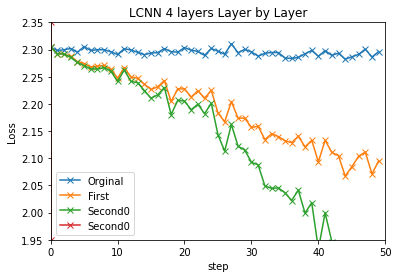

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

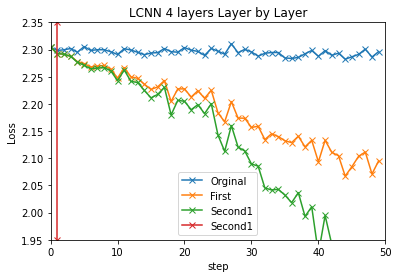

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

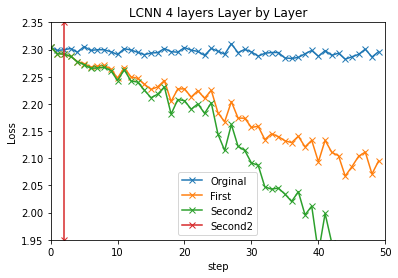

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

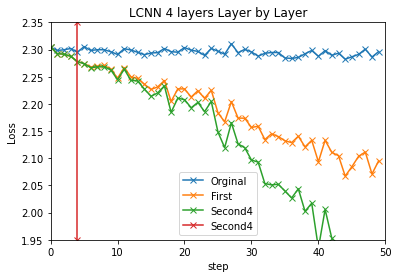

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

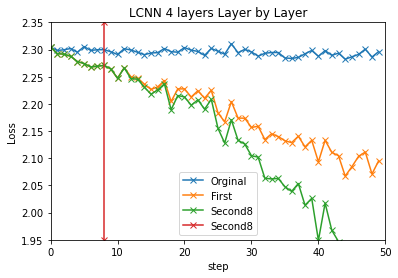

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

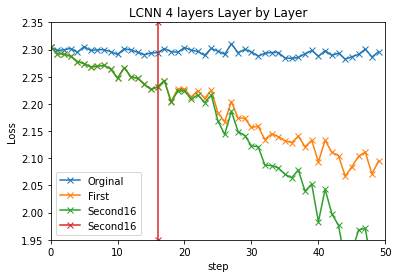

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

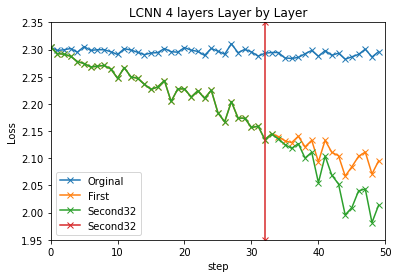

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

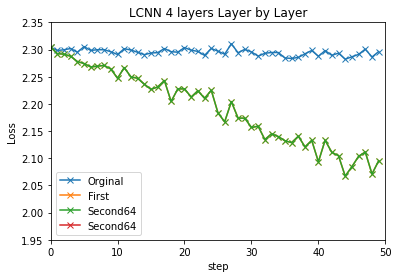

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

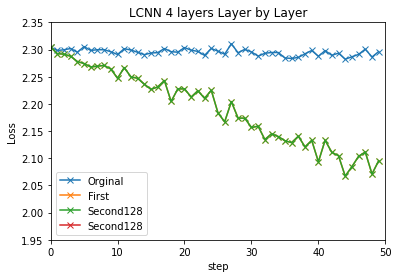

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import widgets
pl=[0,1,2,4,8,16,32,64,128]
tb = widgets.TabBar([str(i) for i in pl])
for i in range(9):
  # Only select the first 3 tabs, and render others in the background.
  with tb.output_to(i):
    plt.plot(out[0][1][:50],'x-',label='Orginal')
    plt.plot(out[1][1][:50],'x-',label='First')
    k=pl[i]
    plt.plot(out[i+2][1][:50],'x-',label='Second'+str(k))
    plt.plot([k,k],[1.95,2.35],'x-',label='Second'+str(k))
    plt.title('LCNN 4 layers Layer by Layer')
    plt.legend()
    plt.xlim([0,50])
    plt.ylim([1.95,2.35])
    plt.ylabel('Loss')
    plt.xlabel('step')
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

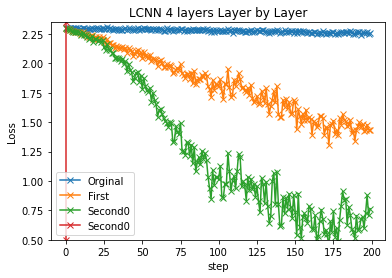

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

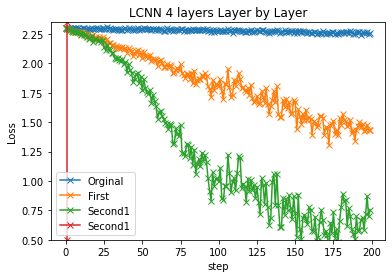

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

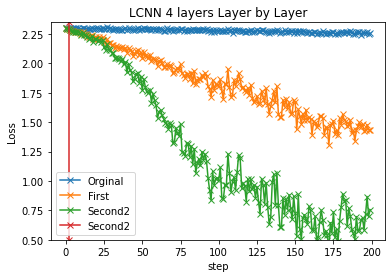

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

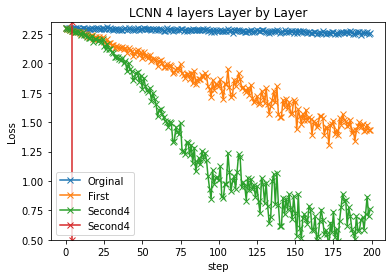

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

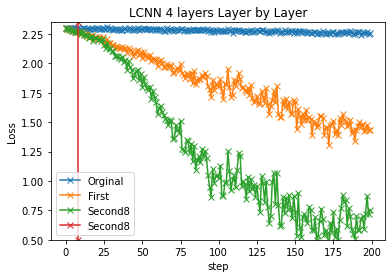

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

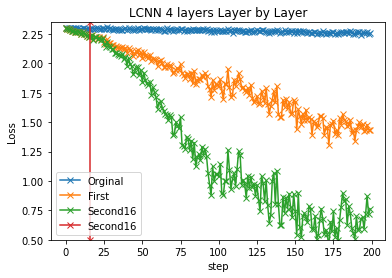

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

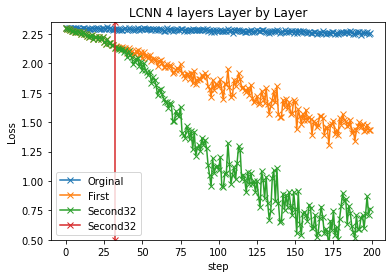

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

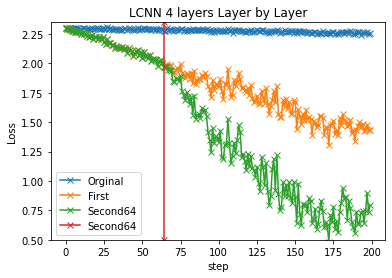

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

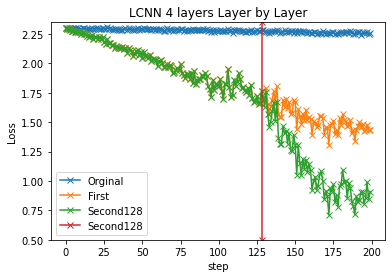

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import widgets
pl=[0,1,2,4,8,16,32,64,128]
tb = widgets.TabBar([str(i) for i in pl])
for i in range(9):
  # Only select the first 3 tabs, and render others in the background.
  with tb.output_to(i):
    plt.plot(out[0][1][:200],'x-',label='Orginal')
    plt.plot(out[1][1][:200],'x-',label='First')
    k=pl[i]
    plt.plot(out[i+2][1][:200],'x-',label='Second'+str(k))
    plt.title('LCNN 4 layers Layer by Layer')
    plt.plot([k,k],[0.5,2.35],'x-',label='Second'+str(k))
    plt.legend()
    plt.ylim([0.5,2.35])
    plt.ylabel('Loss')
    plt.xlabel('step')
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

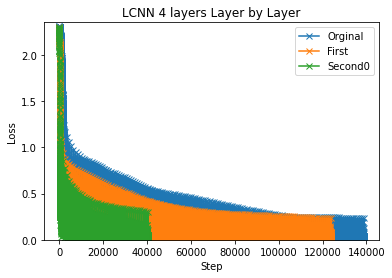

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

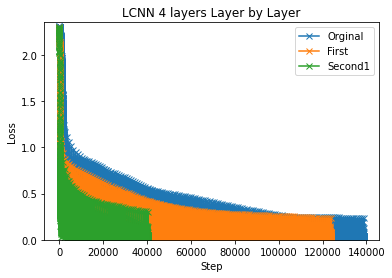

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

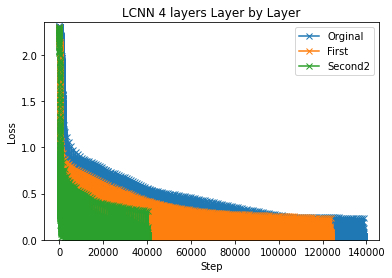

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

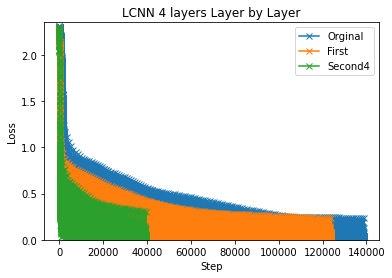

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

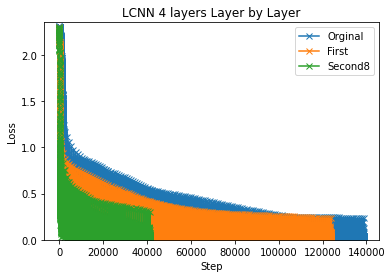

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

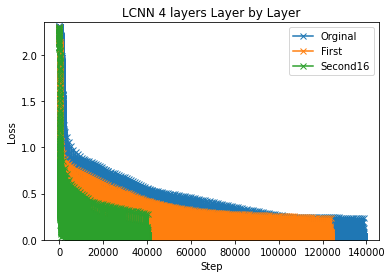

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

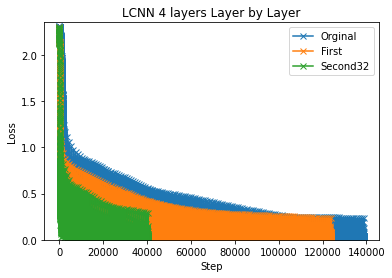

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

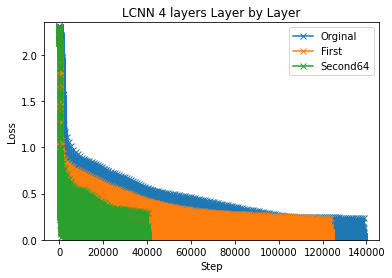

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

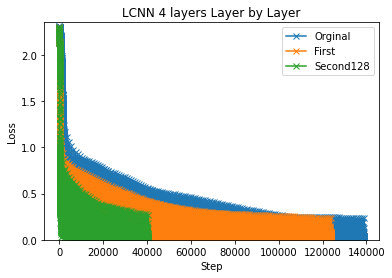

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import widgets
pl=[0,1,2,4,8,16,32,64,128]
tb = widgets.TabBar([str(i) for i in pl])
for i in range(9):
  with tb.output_to(i):
    plt.plot(out[0][1],'x-',label='Orginal')
    plt.plot(out[1][1],'x-',label='First')
    k=pl[i]
    plt.plot(out[i+2][1],'x-',label='Second'+str(k))
    plt.title('LCNN 4 layers Layer by Layer')
    plt.legend()
    plt.ylim([0,2.35])
    plt.ylabel('Loss')
    plt.xlabel('Step')
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

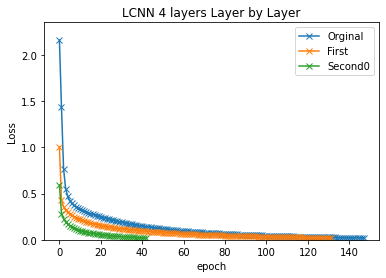

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

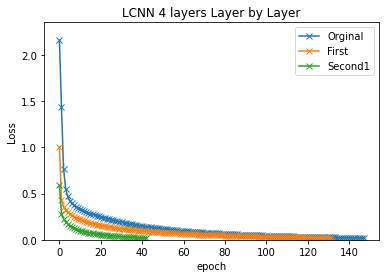

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

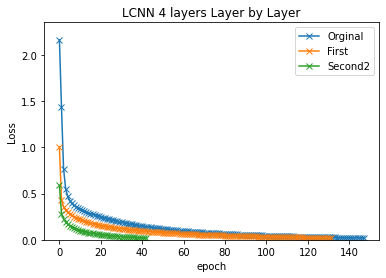

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

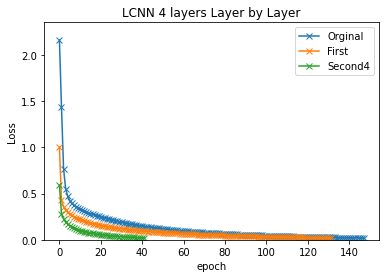

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

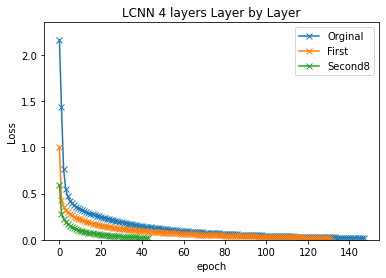

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

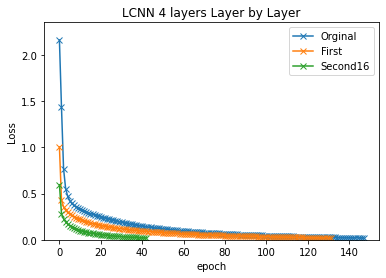

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

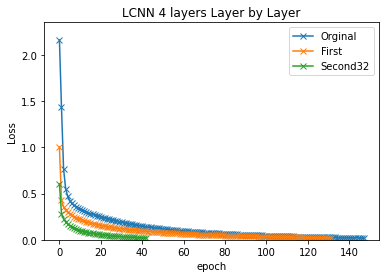

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

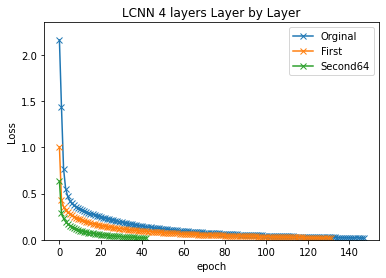

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

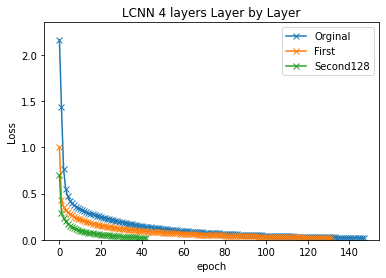

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import widgets
pl=[0,1,2,4,8,16,32,64,128]
tb = widgets.TabBar([str(i) for i in pl])
for i in range(9):
  with tb.output_to(i):
    plt.plot(out[0][0],'x-',label='Orginal')
    plt.plot(out[1][0],'x-',label='First')
    k=pl[i]
    plt.plot(out[i+2][0],'x-',label='Second'+str(k))
    plt.title('LCNN 4 layers Layer by Layer')
    plt.legend()
    plt.ylim([0,2.35])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.show()

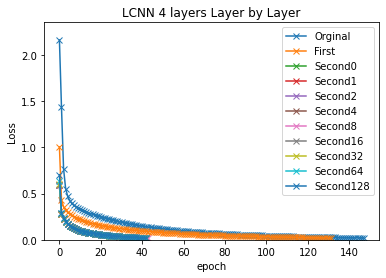

In [ ]:
pl=[0,1,2,4,8,16,32,64,128]
plt.plot(out[0][0],'x-',label='Orginal')
plt.plot(out[1][0],'x-',label='First')
for i in range(9):
    k=pl[i]
    plt.plot(out[i+2][0],'x-',label='Second'+str(k))
plt.title('LCNN 4 layers Layer by Layer')
plt.legend()
plt.ylim([0,2.35])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

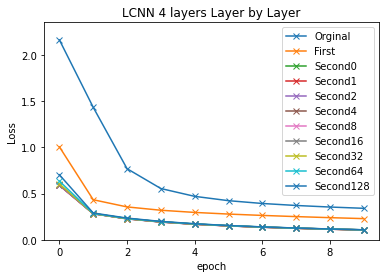

In [ ]:
pl=[0,1,2,4,8,16,32,64,128]
plt.plot(out[0][0][:10],'x-',label='Orginal')
plt.plot(out[1][0][:10],'x-',label='First')
for i in range(9):
    k=pl[i]
    plt.plot(out[i+2][0][:10],'x-',label='Second'+str(k))
plt.title('LCNN 4 layers Layer by Layer')
plt.legend()
plt.ylim([0,2.35])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

## shuffling

In [ ]:
out=[]
for p in [0,1,2,3]:
    #print(p)
    learning_rate = 0.002
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)
    if p>0:
        ad=True
    else:
        ad=False
    if ad:
        dataiter = iter(train_loader)
        images, labels = dataiter.next()
        images = images.view(images.shape[0], -1)

        adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1,shuff=p-1)
        
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0)
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    num_epochs=700
    dev=100
    losslist=[]


    totalloss=[]



    model.fc2.register_forward_hook(get_activation('fc2'))
    #model.fc4.register_forward_hook(get_activation('fc4'))
    #model.fc6.register_forward_hook(get_activation('fc6'))

    count=0
    dd=5
    de=1
    for epoch in range(num_epochs):
        loss_epoch=0
        for i, (images, labels) in enumerate(train_loader):


            

            images = images.view(images.shape[0], -1).to(device)
            labels=labels.to(device)
            #
            # Forward pass
            outputs = model(images).to(device)
            loss = criterion(outputs, labels).to(device)

            totalloss.append(loss.item())


            

            if ad and (p>4):
                if count==dd:
                    with torch.no_grad():
                        output = model(images)
                        adjust(model,activation['fc'+str(2*de)],threshold_u=10,threshold_l=0.1,scale=0.4,ln=2*de+1,oflag=1,shuff=p-1)  
            
            count=count+1
            

        
            loss_epoch=loss_epoch+loss.item()       
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            


                        
                        
            
        loss_epoch=loss_epoch/len(train_loader) 
        losslist.append(loss_epoch)
        
        #print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, loss_epoch),end="\r", flush=True)
        sys.stdout.write('\r'+'Task:{},Epoch [{}/{}], Loss: {:.4f}' .format(p,epoch+1, num_epochs, loss_epoch))
        if loss_epoch<0.02:
            break
    out.append([losslist,totalloss])
np.save('/content/drive/My Drive/LCNN/output1024.npy', out)

Task:0,Epoch [150/700], Loss: 0.0198Adjusting Layer 1, Kernel Nodes: 643, Adptive Nodes157
Task:1,Epoch [119/700], Loss: 0.0199Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
Task:2,Epoch [132/700], Loss: 0.0199Adjusting Layer 1, Kernel Nodes: 368, Adptive Nodes432
Task:3,Epoch [152/700], Loss: 0.0198

Text(0.5, 15.0, 'Step')

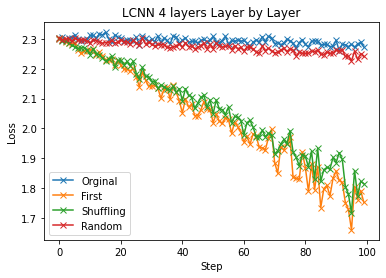

In [ ]:
plt.plot(out[0][1][:100],'x-',label='Orginal')
plt.plot(out[1][1][:100],'x-',label='First')
plt.plot(out[2][1][:100],'x-',label='Shuffling')
plt.plot(out[3][1][:100],'x-',label='Random')

#plt.plot(totalloss[:400],'x-',label='layer by layer')
#plt.plot([50,50],[0,2.5],color='black')
plt.title('LCNN 4 layers Layer by Layer')
plt.savefig('/content/drive/My Drive/LCNN/plot/4Shuffle.pdf')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Step')

Text(0.5, 15.0, 'epoch')

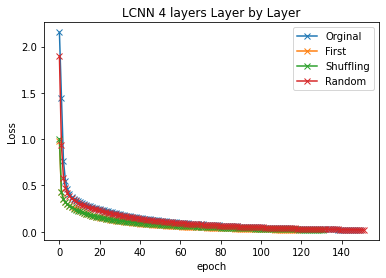

In [ ]:
plt.plot(out[0][0],'x-',label='Orginal')
plt.plot(out[1][0],'x-',label='First')
plt.plot(out[2][0],'x-',label='Shuffling')
plt.plot(out[3][0],'x-',label='Random')

#plt.plot(totalloss[:400],'x-',label='layer by layer')
#plt.plot([50,50],[0,2.5],color='black')
plt.title('LCNN 4 layers Layer by Layer')
plt.savefig('/content/drive/My Drive/LCNN/plot/4Shuffle2.pdf')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

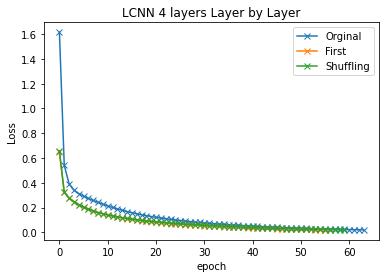

In [ ]:
plt.plot(out[0][0],'x-',label='Orginal')
plt.plot(out[1][0],'x-',label='First')
plt.plot(out[2][0],'x-',label='Shuffling')

#plt.plot(totalloss[:400],'x-',label='layer by layer')
#plt.plot([50,50],[0,2.5],color='black')
plt.title('LCNN 4 layers Layer by Layer')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('epoch')

## NTK initialization

In [ ]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

hidden_size2 = 200

hidden_size3 = 100


num_classes = 10
batch_size = 64


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 

        
        
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2,bias=False)

        
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu2 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, num_classes,bias=False)


        self.fc1.weight.detach().uniform_(-1, 1)
        self.fc1.bias.detach().uniform_(-1, 1)
        self.fc2.weight.detach().uniform_(-1,1)
        self.fc3.weight.detach().uniform_(-1, 1)
        self.fc3.bias.detach().uniform_(-1, 1)
        self.fc4.weight.detach().uniform_(-1,1)





        self.lsm=nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        out = self.fc1(x)
        out = out/np.sqrt(input_size)
        out = self.relu1(out)
        out = self.fc2(out)
        out = out/np.sqrt(hidden_size1)
        out = self.fc3(out)
        out = out/np.sqrt(hidden_size2)
        out = self.relu2(out)
        out = self.fc4(out)
        out = out/np.sqrt(hidden_size3)
        out = self.lsm(out)
        return out

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


In [ ]:
out=[]
for p in [-2,-1,0,1,5,10,50]:
    print(p)
    learning_rate = 0.1
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)
    if p>-2:
        ad=True
    else:
        ad=False
    if ad:
        dataiter = iter(train_loader)
        images, labels = dataiter.next()
        images = images.view(images.shape[0], -1)

        adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)
        
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    num_epochs=700
    dev=100
    losslist=[]


    totalloss=[]



    model.fc2.register_forward_hook(get_activation('fc2'))
    #model.fc4.register_forward_hook(get_activation('fc4'))
    #model.fc6.register_forward_hook(get_activation('fc6'))

    count=0
    dd=p
    de=1
    for epoch in range(num_epochs):
        loss_epoch=0
        for i, (images, labels) in enumerate(train_loader):


            

            images = images.view(images.shape[0], -1).to(device)
            labels=labels.to(device)
            #
            # Forward pass
            outputs = model(images).to(device)
            loss = criterion(outputs, labels).to(device)


            
            if count<10:
                print(count,loss.item())

            if ad:
                if count==dd:
                    with torch.no_grad():
                        output = model(images)
                        adjust(model,activation['fc'+str(2*de)],threshold_u=10,threshold_l=0.1,scale=0.4,ln=2*de+1,oflag=1)  
            
            count=count+1
            
            totalloss.append(loss.item())
            #if epoch<1:
            #    print(count,loss.item())
            loss_epoch=loss_epoch+loss.item()       
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            


                        
                        
            
        loss_epoch=loss_epoch/len(train_loader) 
        losslist.append(loss_epoch)
        
        #print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, loss_epoch))
        if loss_epoch<0.02:
            break
    out.append([losslist,totalloss])
    accuracy(model,valloader)
np.save('/content/drive/My Drive/LCNN/output4layerNTK.npy', out)

-2
0 2.3133461475372314
1 2.305601119995117
2 2.323280096054077
3 2.300830841064453
4 2.316904067993164
5 2.3222451210021973
6 2.3136038780212402
7 2.3089792728424072
8 2.3100433349609375
9 2.3151493072509766
Accuracy: 97.5800 %
None
-1
Adjusting Layer 1, Kernel Nodes: 649, Adptive Nodes151
0 2.3133461475372314
1 2.305229663848877
2 2.3224666118621826
3 2.298360824584961
4 2.3133885860443115
5 2.3170480728149414
6 2.3073995113372803
7 2.299197196960449
8 2.3011631965637207
9 2.303084373474121
Accuracy: 97.0200 %
None
0
Adjusting Layer 1, Kernel Nodes: 649, Adptive Nodes151
0 2.3133461475372314
Adjusting Layer 3, Kernel Nodes: 85, Adptive Nodes15
1 2.3051674365997314
2 2.322171449661255
3 2.2963500022888184
4 2.3106367588043213
5 2.312000274658203
6 2.3012542724609375
7 2.28884220123291
8 2.2939207553863525
9 2.2938787937164307
Accuracy: 96.9600 %
None
1
Adjusting Layer 1, Kernel Nodes: 649, Adptive Nodes151
0 2.3133461475372314
1 2.305229663848877
Adjusting Layer 3, Kernel Nodes: 83, A

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

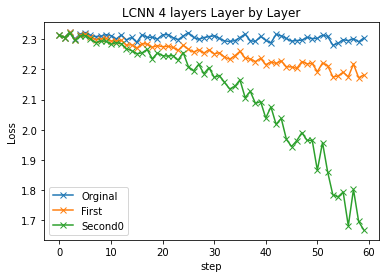

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

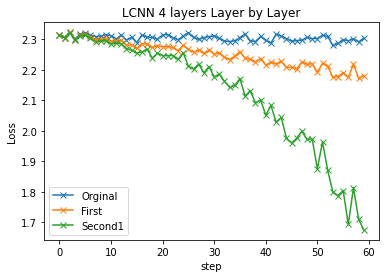

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

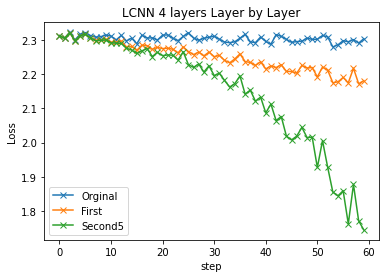

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

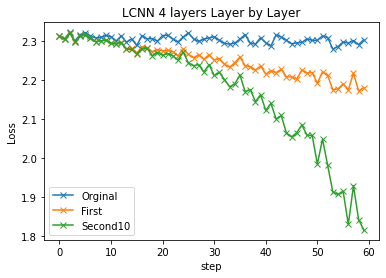

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

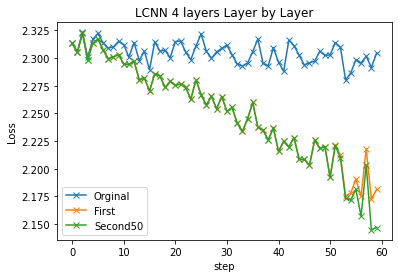

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import widgets
pl=[0,1,5,10,50]
tb = widgets.TabBar([str(i) for i in pl])
for i in range(5):
  # Only select the first 3 tabs, and render others in the background.
  with tb.output_to(i):
    plt.plot(out[0][1][:60],'x-',label='Orginal')
    plt.plot(out[1][1][:60],'x-',label='First')
    k=pl[i]
    plt.plot(out[i+2][1][:60],'x-',label='Second'+str(k))
    #plt.plot([k,k],[1.95,2.35],'x-',label='Second'+str(k))
    plt.title('LCNN 4 layers Layer by Layer')
    plt.legend()
    #plt.xlim([0,70])
    #plt.ylim([0,0.11])
    plt.ylabel('Loss')
    plt.xlabel('step')
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

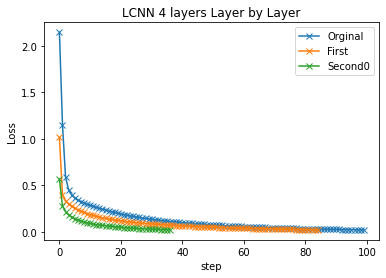

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

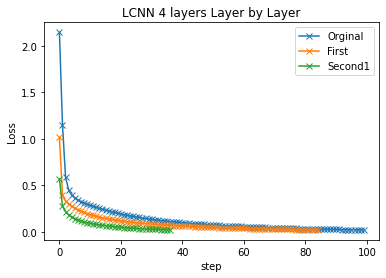

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

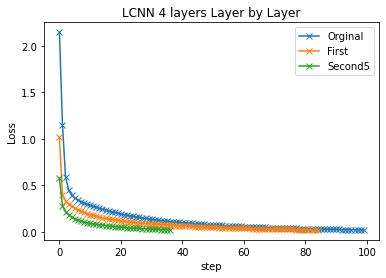

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

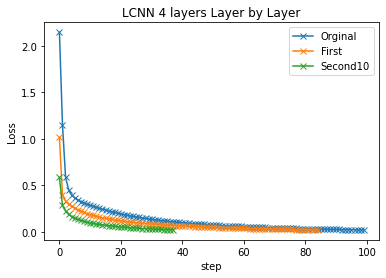

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

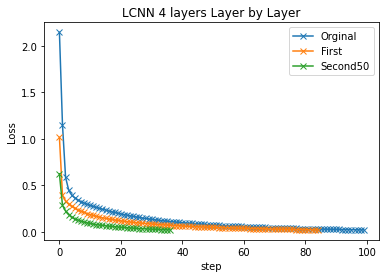

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import widgets
pl=[0,1,5,10,50]
tb = widgets.TabBar([str(i) for i in pl])
for i in range(5):
  # Only select the first 3 tabs, and render others in the background.
  with tb.output_to(i):
    plt.plot(out[0][0],'x-',label='Orginal')
    plt.plot(out[1][0],'x-',label='First')
    k=pl[i]
    plt.plot(out[i+2][0],'x-',label='Second'+str(k))
    #plt.plot([k,k],[1.95,2.35],'x-',label='Second'+str(k))
    plt.title('LCNN 4 layers Layer by Layer')
    plt.legend()
    #plt.xlim([0,70])
    #plt.ylim([0,0.11])
    plt.ylabel('Loss')
    plt.xlabel('step')
    plt.show()

## MSE

In [ ]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

hidden_size2 = 200

hidden_size3 = 100


num_classes = 10
batch_size = 64


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 

        
        
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2,bias=False)

        
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu2 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, num_classes,bias=False)


    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.relu2(out)
        out = self.fc4(out)
        return out

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


In [ ]:
out=[]
for p in [-2,-1,0,1,2,4,8,16,32,64]:
    print(p)
    learning_rate = 0.002
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)
    if p>-2:
        ad=True
    else:
        ad=False
    if ad:
        dataiter = iter(train_loader)
        images, labels = dataiter.next()
        images = images.view(images.shape[0], -1)

        adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)
        
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    num_epochs=700
    dev=100
    losslist=[]


    totalloss=[]


    model.fc2.register_forward_hook(get_activation('fc2'))

    count=0
    dd=p
    de=1
    for epoch in range(num_epochs):
        loss_epoch=0
        for i, (images, labels) in enumerate(train_loader):
                        

            images = images.view(images.shape[0], -1).to(device)
            outputs = model(images).to(device)
            

            labels =one_hot(labels,num_classes).to(device)
            loss = criterion(outputs, labels).to(device)
            if count<10:
                print(count,loss.item())

            
            
            
            

            if ad:
                if count==dd:
                    with torch.no_grad():
                        output = model(images)
                        adjust(model,activation['fc'+str(2*de)],threshold_u=10,threshold_l=0.1,scale=0.4,ln=2*de+1,oflag=1)  
            
            count=count+1
            
            totalloss.append(loss.item())
            #if epoch<1:
            #    print(count,loss.item())
            loss_epoch=loss_epoch+loss.item()       
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            


                        
                        
            
        loss_epoch=loss_epoch/len(train_loader) 
        losslist.append(loss_epoch)
        
        #print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, loss_epoch))
        if loss_epoch<0.01:
            break
    out.append([losslist,totalloss])
    accuracy(model,valloader)
np.save('/content/drive/My Drive/LCNN/output4layerMSE.npy', out)

-2
0 0.10614407062530518
1 0.10434945672750473
2 0.10477729886770248
3 0.10424675047397614
4 0.10285767167806625
5 0.10460706055164337
6 0.10257144272327423
7 0.10150071233510971
8 0.10155613720417023
9 0.09986238926649094
Accuracy: 96.2100 %
-1
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
0 0.10614407062530518
1 0.10101417452096939
2 0.09667960554361343
3 0.09284624457359314
4 0.09051427990198135
5 0.08823847025632858
6 0.08923836052417755
7 0.08919678628444672
8 0.09042167663574219
9 0.08882998675107956
Accuracy: 96.3100 %
0
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
0 0.10614407062530518
Adjusting Layer 3, Kernel Nodes: 81, Adptive Nodes19
1 0.10081813484430313
2 0.09597741812467575
3 0.09197807312011719
4 0.08986443281173706
5 0.08772983402013779
6 0.08908895403146744
7 0.08926195651292801
8 0.09059669822454453
9 0.08839605003595352
Accuracy: 96.2300 %
1
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
0 0.10614407062530518
1 0.10101417452096939
Adjustin

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

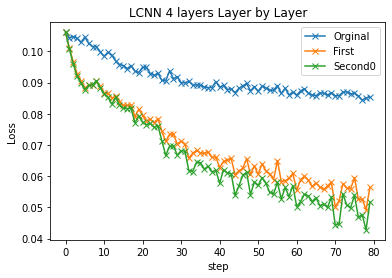

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

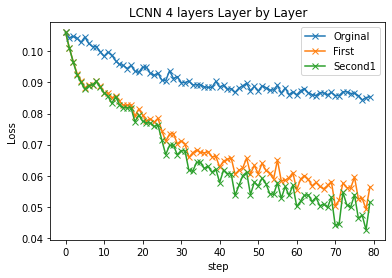

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

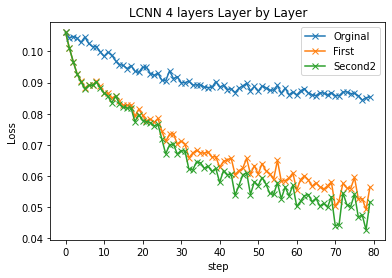

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

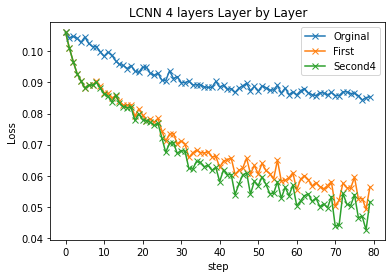

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

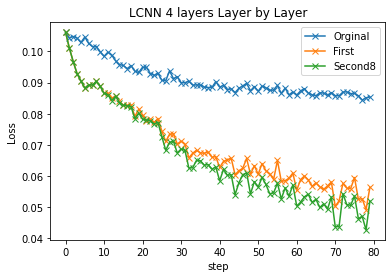

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

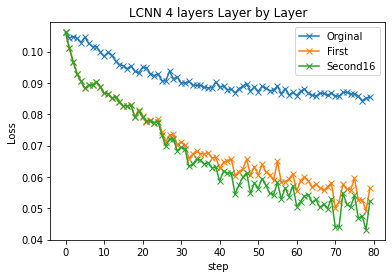

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

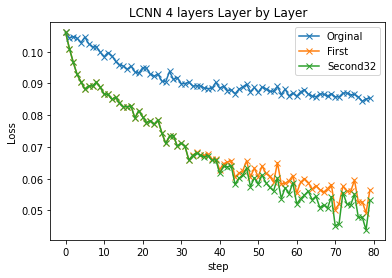

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

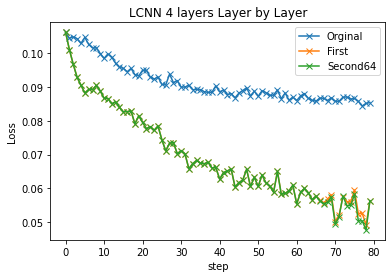

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import widgets
pl=[0,1,2,4,8,16,32,64]
tb = widgets.TabBar([str(i) for i in pl])
for i in range(8):
  # Only select the first 3 tabs, and render others in the background.
  with tb.output_to(i):
    plt.plot(out[0][1][:80],'x-',label='Orginal')
    plt.plot(out[1][1][:80],'x-',label='First')
    k=pl[i]
    plt.plot(out[i+2][1][:80],'x-',label='Second'+str(k))
    #plt.plot([k,k],[1.95,2.35],'x-',label='Second'+str(k))
    plt.title('LCNN 4 layers Layer by Layer')
    plt.legend()
    #plt.xlim([0,70])
    #plt.ylim([0,0.11])
    plt.ylabel('Loss')
    plt.xlabel('step')
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

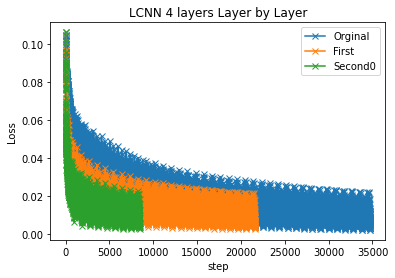

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

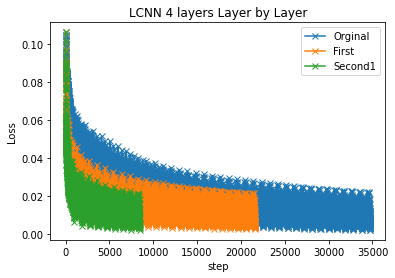

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

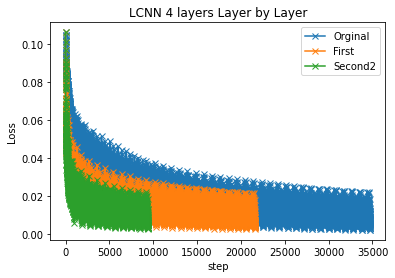

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

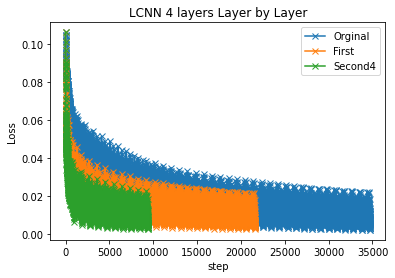

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

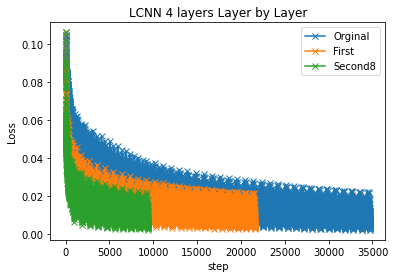

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

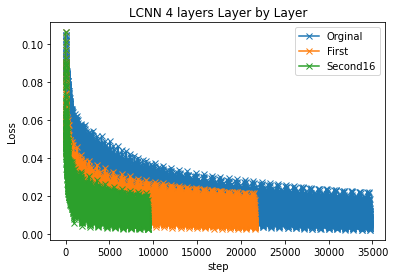

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

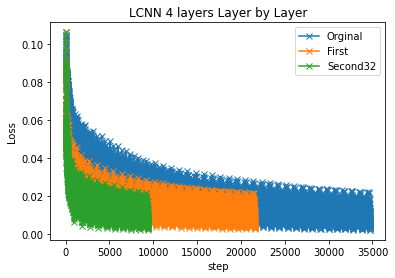

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

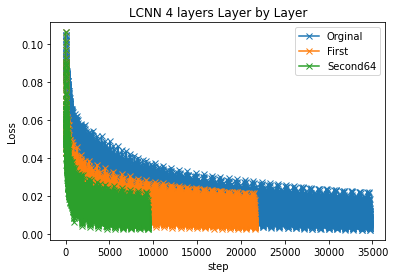

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import widgets
pl=[0,1,2,4,8,16,32,64]
tb = widgets.TabBar([str(i) for i in pl])
for i in range(8):
  # Only select the first 3 tabs, and render others in the background.
  with tb.output_to(i):
    plt.plot(out[0][1],'x-',label='Orginal')
    plt.plot(out[1][1],'x-',label='First')
    k=pl[i]
    plt.plot(out[i+2][1],'x-',label='Second'+str(k))
    #plt.plot([k,k],[1.95,2.35],'x-',label='Second'+str(k))
    plt.title('LCNN 4 layers Layer by Layer')
    plt.legend()
    #plt.xlim([0,70])
    #plt.ylim([0,0.11])
    plt.ylabel('Loss')
    plt.xlabel('step')
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

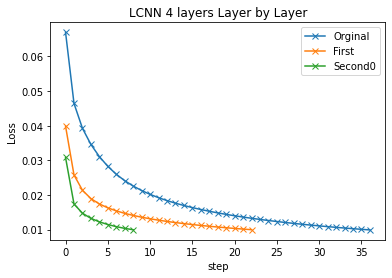

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

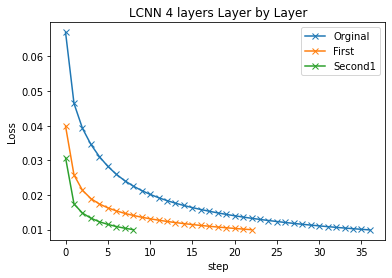

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

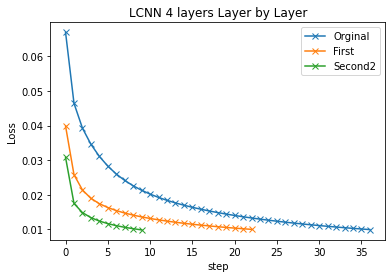

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

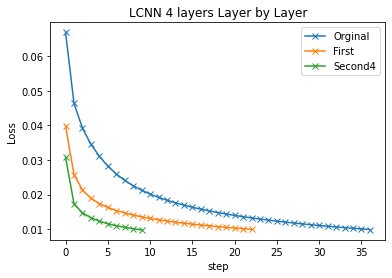

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

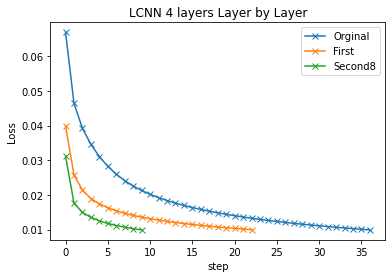

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

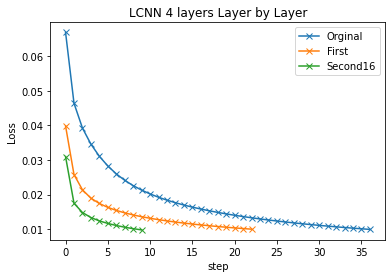

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

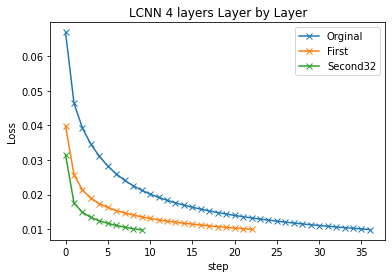

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

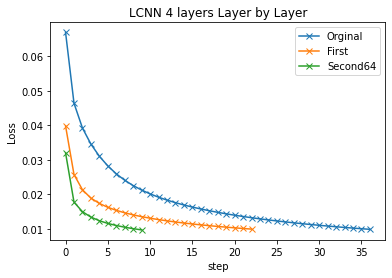

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import widgets
pl=[0,1,2,4,8,16,32,64]
tb = widgets.TabBar([str(i) for i in pl])
for i in range(8):
  # Only select the first 3 tabs, and render others in the background.
  with tb.output_to(i):
    plt.plot(out[0][0],'x-',label='Orginal')
    plt.plot(out[1][0],'x-',label='First')
    k=pl[i]
    plt.plot(out[i+2][0],'x-',label='Second'+str(k))
    #plt.plot([k,k],[1.95,2.35],'x-',label='Second'+str(k))
    plt.title('LCNN 4 layers Layer by Layer')
    plt.legend()
    #plt.xlim([0,70])
    #plt.ylim([0,0.11])
    plt.ylabel('Loss')
    plt.xlabel('step')
    plt.show()

## NTK & MSE

In [ ]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

hidden_size2 = 200

hidden_size3 = 100


num_classes = 10
batch_size = 64


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 

        
        
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2,bias=False)

        
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu2 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, num_classes,bias=False)


        self.fc1.weight.detach().uniform_(-1, 1)
        self.fc1.bias.detach().uniform_(-1, 1)
        self.fc2.weight.detach().uniform_(-1,1)
        self.fc3.weight.detach().uniform_(-1, 1)
        self.fc3.bias.detach().uniform_(-1, 1)
        self.fc4.weight.detach().uniform_(-1,1)





        self.lsm=nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        out = self.fc1(x)
        out = out/np.sqrt(input_size)
        out = self.relu1(out)
        out = self.fc2(out)
        out = out/np.sqrt(hidden_size1)
        out = self.fc3(out)
        out = out/np.sqrt(hidden_size2)
        out = self.relu2(out)
        out = self.fc4(out)
        out = out/np.sqrt(hidden_size3)
        return out

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


In [ ]:
out=[]
for p in [-2,-1,0,1,10,100,1000,10000]:
    print(p)
    learning_rate = 0.05
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)
    if p>-2:
        ad=True
    else:
        ad=False
    if ad:
        dataiter = iter(train_loader)
        images, labels = dataiter.next()
        images = images.view(images.shape[0], -1)

        adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)
        
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    num_epochs=700
    dev=100
    losslist=[]


    totalloss=[]


    model.fc2.register_forward_hook(get_activation('fc2'))

    count=0
    dd=p
    de=1
    for epoch in range(num_epochs):
        loss_epoch=0
        for i, (images, labels) in enumerate(train_loader):
                        

            images = images.view(images.shape[0], -1).to(device)
            outputs = model(images).to(device)
            

            labels =one_hot(labels,num_classes).to(device)
            loss = criterion(outputs, labels).to(device)
            if count<10:
                print(count,loss.item())

            
            
            
            

            if ad:
                if count==dd:
                    with torch.no_grad():
                        output = model(images)
                        adjust(model,activation['fc'+str(2*de)],threshold_u=10,threshold_l=0.1,scale=0.4,ln=2*de+1,oflag=1)  
            
            count=count+1
            
            totalloss.append(loss.item())
            #if epoch<1:
            #    print(count,loss.item())
            loss_epoch=loss_epoch+loss.item()       
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            


                        
                        
            
        loss_epoch=loss_epoch/len(train_loader) 
        losslist.append(loss_epoch)
        
        print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, loss_epoch))
        if loss_epoch<0.01:
            break
    out.append([losslist,totalloss])
    accuracy(model,valloader)
np.save('/content/drive/My Drive/LCNN/output4layerNTKMSE.npy', out)

-2
0 0.11053480207920074
1 0.10940179973840714
2 0.11264876276254654
3 0.10789944976568222
4 0.1113886758685112
5 0.11204105615615845
6 0.11051731556653976
7 0.10991957038640976
8 0.10970921814441681
9 0.11130920797586441
Epoch [1/700], Loss: 0.0945
Epoch [2/700], Loss: 0.0865
Epoch [3/700], Loss: 0.0834
Epoch [4/700], Loss: 0.0803
Epoch [5/700], Loss: 0.0771
Epoch [6/700], Loss: 0.0739
Epoch [7/700], Loss: 0.0707
Epoch [8/700], Loss: 0.0677
Epoch [9/700], Loss: 0.0650
Epoch [10/700], Loss: 0.0625
Epoch [11/700], Loss: 0.0604
Epoch [12/700], Loss: 0.0585
Epoch [13/700], Loss: 0.0568
Epoch [14/700], Loss: 0.0552
Epoch [15/700], Loss: 0.0539
Epoch [16/700], Loss: 0.0526
Epoch [17/700], Loss: 0.0515
Epoch [18/700], Loss: 0.0505
Epoch [19/700], Loss: 0.0495
Epoch [20/700], Loss: 0.0486
Epoch [21/700], Loss: 0.0478
Epoch [22/700], Loss: 0.0470
Epoch [23/700], Loss: 0.0462
Epoch [24/700], Loss: 0.0455
Epoch [25/700], Loss: 0.0448
Epoch [26/700], Loss: 0.0442
Epoch [27/700], Loss: 0.0436
Epoc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

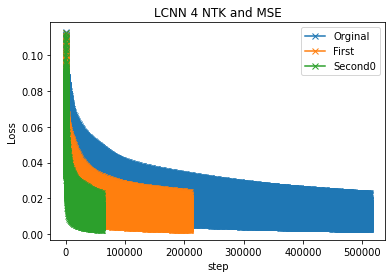

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

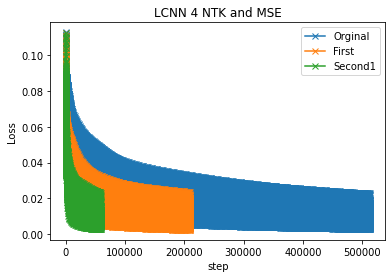

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

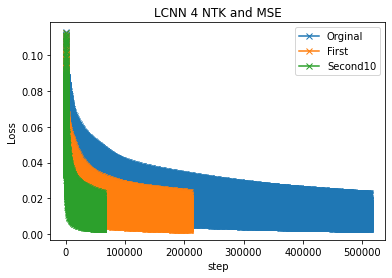

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

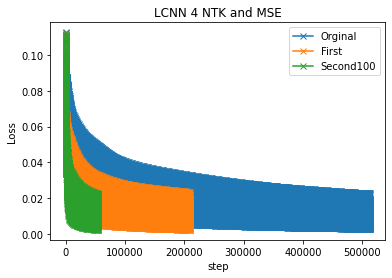

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

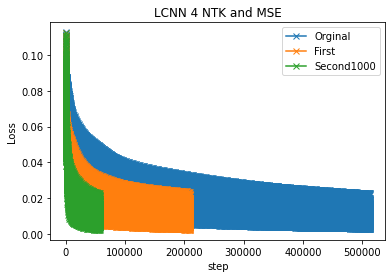

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

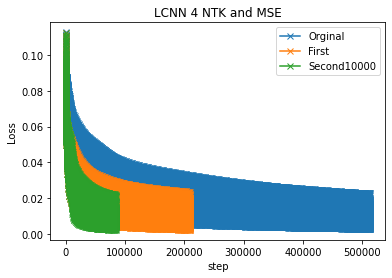

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import widgets
pl=[0,1,10,100,1000,10000]
tb = widgets.TabBar([str(i) for i in pl])
for i in range(6):
  # Only select the first 3 tabs, and render others in the background.
  with tb.output_to(i):
    plt.plot(out[0][1],'x-',label='Orginal')
    plt.plot(out[1][1],'x-',label='First')
    k=pl[i]
    plt.plot(out[i+2][1],'x-',label='Second'+str(k))
    #plt.plot([k,k],[1.95,2.35],'x-',label='Second'+str(k))
    plt.title('LCNN 4 NTK and MSE')
    plt.legend()
    #plt.xlim([0,70])
    #plt.ylim([0,0.11])
    plt.ylabel('Loss')
    plt.xlabel('step')
    plt.show()

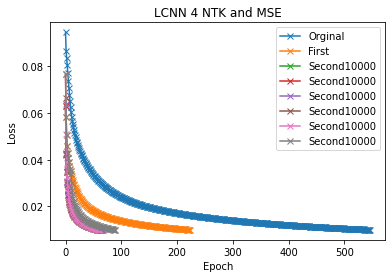

In [ ]:
plt.plot(out[0][0],'x-',label='Orginal')
plt.plot(out[1][0],'x-',label='First')
for i in range(6):
    plt.plot(out[i+2][0],'x-',label='Second'+str(k))
    plt.title('LCNN 4 NTK and MSE')
plt.legend()
#plt.xlim([0,70])
#plt.ylim([0,0.11])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Sparsity

In [6]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784
out=[]
bs=100
for layersize in [1,2,3]:

    hidden_size1 = 5*layersize

    hidden_size2 = 4*layersize

    hidden_size3 = 3*layersize


    num_classes = 10
    batch_size = 64


    class NeuralNet(nn.Module):
        def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,num_classes):
            super(NeuralNet, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size1) 

            
            
            
            self.relu1 = nn.ReLU()
            self.fc2 = nn.Linear(hidden_size1, hidden_size2,bias=False)

            
            
            self.fc3 = nn.Linear(hidden_size2, hidden_size3)
            self.relu2 = nn.ReLU()
            self.fc4 = nn.Linear(hidden_size3, num_classes,bias=False)


            self.fc1.weight.detach().uniform_(-1, 1)
            self.fc1.bias.detach().uniform_(-1, 1)
            self.fc2.weight.detach().uniform_(-1,1)
            self.fc3.weight.detach().uniform_(-1, 1)
            self.fc3.bias.detach().uniform_(-1, 1)
            self.fc4.weight.detach().uniform_(-1,1)





            self.lsm=nn.LogSoftmax(dim=1)
        
        def forward(self, x):
            out = self.fc1(x)
            out = out/np.sqrt(input_size)
            out = self.relu1(out)
            out = self.fc2(out)
            out = out/np.sqrt(hidden_size1)
            out = self.fc3(out)
            out = out/np.sqrt(hidden_size2)
            out = self.relu2(out)
            out = self.fc4(out)
            out = out/np.sqrt(hidden_size3)
            out = self.lsm(out)
            return out

    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    p=10
    learning_rate = 0.1
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)
    if p>-2:
        ad=True
    else:
        ad=False
    if ad:
        dataiter = iter(train_loader)
        images, labels = dataiter.next()
        images = images.view(images.shape[0], -1)

        adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)
        
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    num_epochs=700
    dev=100
    losslist=[]


    totalloss=[]



    model.fc2.register_forward_hook(get_activation('fc2'))
    #model.fc4.register_forward_hook(get_activation('fc4'))
    #model.fc6.register_forward_hook(get_activation('fc6'))

    count=0
    dd=p
    de=1
    lo=0
    for epoch in range(num_epochs):
        loss_epoch=0
        for i, (images, labels) in enumerate(train_loader):
            if i>bs:
                continue


            

            images = images.view(images.shape[0], -1).to(device)
            labels=labels.to(device)
            #
            # Forward pass
            outputs = model(images).to(device)
            loss = criterion(outputs, labels).to(device)


            
            if count<10:
                print(count,loss.item())

            if ad:
                if count==dd:
                    with torch.no_grad():
                        output = model(images)
                        adjust(model,activation['fc'+str(2*de)],threshold_u=10,threshold_l=0.1,scale=0.4,ln=2*de+1,oflag=1)  
            
            count=count+1
            
            totalloss.append(loss.item())
            #if epoch<1:
            #    print(count,loss.item())
            loss_epoch=loss_epoch+loss.item()       
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            


                        
                        
            
        loss_epoch=loss_epoch/bs 
        losslist.append(loss_epoch)
        
        print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, loss_epoch))
        if loss_epoch<0.02 or np.abs(loss_epoch-lo)<0.001:
            break
        lo=loss_epoch
    ac=accuracy(model,valloader)
    out.append([losslist,totalloss,ac])
    
np.save('/content/drive/My Drive/LCNN/output4layerNTK.npy', out)


Adjusting Layer 1, Kernel Nodes: 5, Adptive Nodes0
0 2.317617177963257
1 2.323528289794922
2 2.302340269088745
3 2.3093535900115967
4 2.305039882659912
5 2.323378562927246
6 2.3271827697753906
7 2.3107662200927734
8 2.319885492324829
9 2.299215793609619
Adjusting Layer 3, Kernel Nodes: 2, Adptive Nodes1
Epoch [1/700], Loss: 2.3252
Epoch [2/700], Loss: 2.3090
Epoch [3/700], Loss: 2.2817
Epoch [4/700], Loss: 2.3149
Epoch [5/700], Loss: 2.3256
Epoch [6/700], Loss: 2.3256
Accuracy: 10.2800 %
Adjusting Layer 1, Kernel Nodes: 10, Adptive Nodes0
0 2.320213794708252
1 2.304981231689453
2 2.317094564437866
3 2.304933547973633
4 2.2931480407714844
5 2.2971510887145996
6 2.2986302375793457
7 2.3096094131469727
8 2.2955949306488037
9 2.292982816696167
Adjusting Layer 3, Kernel Nodes: 5, Adptive Nodes1
Epoch [1/700], Loss: 2.2602
Epoch [2/700], Loss: 2.2001
Epoch [3/700], Loss: 2.1717
Epoch [4/700], Loss: 1.9886
Epoch [5/700], Loss: 1.8617
Epoch [6/700], Loss: 1.7911
Epoch [7/700], Loss: 1.6949
Epo